# Profiling NYC Collisions Data 


### Key Questions
- What fields are there and are they useful? 
- Are the fields missing data?
- Are there significant gaps in the data over time?
- Are there inconsistencies in the total number of people injured or killed and their respective breakdowns into motorist, pedestrian, and cyclist?
- Are many collisions missing location data? 
- Does 'location' match 'latititude' and 'longitude'?
- Are collision locations near NYC? 

### Data Sources
- Collision data obtained from https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95
 

In [1]:
from datetime import datetime
import math
import matplotlib.pyplot as plt
import pandas as pd
import pandahelper.reports as ph
import scipy.stats

In [2]:
DATA_LOC = "data/raw/Collisions.csv"

In [3]:
data = pd.read_csv(
    DATA_LOC, dtype={"ZIP CODE": "object"}
)  # read_csv interprets zip code as mixed type

# Overview of DataFrame

In [4]:
ph.DataFrameProfile(data)

DataFrame-Level Info
----------------------  -------------
DF Shape                (1843227, 29)
Duplicated Rows         0

Series Name                    Data Type
-----------------------------  -----------
CRASH DATE                     object
CRASH TIME                     object
BOROUGH                        object
ZIP CODE                       object
LATITUDE                       float64
LONGITUDE                      float64
LOCATION                       object
ON STREET NAME                 object
CROSS STREET NAME              object
OFF STREET NAME                object
NUMBER OF PERSONS INJURED      float64
NUMBER OF PERSONS KILLED       float64
NUMBER OF PEDESTRIANS INJURED  int64
NUMBER OF PEDESTRIANS KILLED   int64
NUMBER OF CYCLIST INJURED      int64
NUMBER OF CYCLIST KILLED       int64
NUMBER OF MOTORIST INJURED     int64
NUMBER OF MOTORIST KILLED      int64
CONTRIBUTING FACTOR VEHICLE 1  object
CONTRIBUTING FACTOR VEHICLE 2  object
CONTRIBUTING FACTOR VEHICLE 3  obj

# Examining individual fields (columns)

In [5]:
collision_id_report = ph.SeriesProfile(data["COLLISION_ID"])
collision_id_report

COLLISION_ID Info
-------------------  -------
Data Type            int64
Count                1843227
Unique Values        1843227
Null Values          0

  Value    Count  % of total
-------  -------  ------------
4407480        1  0.00%
3243891        1  0.00%
3245102        1  0.00%
3250580        1  0.00%
3244768        1  0.00%
3242226        1  0.00%
3240484        1  0.00%
3247558        1  0.00%
3248872        1  0.00%
3249533        1  0.00%
3254650        1  0.00%
3245742        1  0.00%
3253876        1  0.00%
3244652        1  0.00%
3249707        1  0.00%
3244030        1  0.00%
3251000        1  0.00%
3250339        1  0.00%
3255595        1  0.00%
3246354        1  0.00%
3868944        1  0.00%
3863860        1  0.00%
3863359        1  0.00%
3869882        1  0.00%
 233172        1  0.00%

Statistic                             Value
-------------------------  ----------------
count                           1.84323e+06
min                            22
1%               

Collision_ID is the primary key according to the dataset dictionary. We confirm that all its values are unique.

In [6]:
time_report = ph.SeriesProfile(data["CRASH TIME"])
date_report = ph.SeriesProfile(data["CRASH DATE"])
time_report, date_report

(CRASH TIME Info
 -----------------  -------
 Data Type          object
 Count              1843227
 Unique Values      1440
 Null Values        0
 
 Value      Count  % of total
 -------  -------  ------------
 16:00      26281  1.43%
 17:00      25760  1.40%
 15:00      25521  1.38%
 18:00      23802  1.29%
 14:00      23411  1.27%
 13:00      21776  1.18%
 9:00       19629  1.06%
 19:00      19599  1.06%
 12:00      19539  1.06%
 16:30      19059  1.03%
 14:30      18268  0.99%
 8:00       18085  0.98%
 10:00      18030  0.98%
 17:30      17846  0.97%
 11:00      17752  0.96%
 0:00       16998  0.92%
 18:30      15877  0.86%
 20:00      15764  0.86%
 13:30      15329  0.83%
 8:30       15282  0.83%
 3:59          75  0.00%
 3:51          75  0.00%
 4:02          74  0.00%
 4:31          73  0.00%
 3:31          70  0.00%
 
 
 ,
 CRASH DATE Info
 -----------------  -------
 Data Type          object
 Count              1843227
 Unique Values      3430
 Null Values        0
 
 Value  

__There are no obvious issues with the time and  date info__
- There are no null values in CRASH TIME and CRASH DATE
- All 1440 minutes in a day are represented in time data
- Times tend to be rounded estimates. For example: 16:00 is more common that 16:02, which is unsurprising
- ~3400 unique dates correspond to 9+ years of data (which is what we have)

In [7]:
loc_report = ph.SeriesProfile(data["LOCATION"])
lat_report = ph.SeriesProfile(data["LATITUDE"])
long_report = ph.SeriesProfile(data["LONGITUDE"])
loc_report, lat_report, long_report

(LOCATION Info
 ---------------  -------
 Data Type        object
 Count            1627931
 Unique Values    243859
 Null Values      215296
 
 Value                        Count  % of total
 -------------------------  -------  ------------
 (0.0, 0.0)                    2086  0.13%
 (40.861862, -73.91282)         685  0.04%
 (40.608757, -74.038086)        670  0.04%
 (40.696033, -73.98453)         646  0.04%
 (40.8047, -73.91243)           597  0.04%
 (40.6960346, -73.9845292)      587  0.04%
 (40.7606005, -73.9643142)      474  0.03%
 (40.820305, -73.89083)         467  0.03%
 (40.798256, -73.82744)         462  0.03%
 (40.7572323, -73.9897922)      456  0.03%
 (40.675735, -73.89686)         448  0.03%
 (40.77077, -73.91727)          443  0.03%
 (40.604153, -74.05198)         440  0.03%
 (40.6757357, -73.8968533)      435  0.03%
 (40.6585778, -73.8906229)      418  0.03%
 (40.733536, -73.87035)         415  0.03%
 (40.658577, -73.89063)         408  0.03%
 (40.7606, -73.96434)      

In [8]:
percent_missing_loc = sum(data["LOCATION"].isna()) / len(data)
percent_missing_loc

0.11680384456173873

__~12% of collisions are missing location data__
- LOCATION is just the tuple, (LATITUDE, LONGITUDE)
- Some lat-long coordinates are invalid. For example: (0, 0) or a latitiude of 43.3444 (max latitude), which is far from NYC

In [9]:
injured_report = ph.SeriesProfile(data["NUMBER OF PERSONS INJURED"])
pedestrian_injured_report = ph.SeriesProfile(data["NUMBER OF PEDESTRIANS INJURED"])
cyclist_injured_report = ph.SeriesProfile(data["NUMBER OF CYCLIST INJURED"])
motorist_injured_report = ph.SeriesProfile(data["NUMBER OF MOTORIST INJURED"])
injured_report, pedestrian_injured_report, cyclist_injured_report, motorist_injured_report

(NUMBER OF PERSONS INJURED Info
 --------------------------------  -------
 Data Type                         float64
 Count                             1843209
 Unique Values                     27
 Null Values                       18
 
   Value    Count  % of total
 -------  -------  ------------
       0  1460903  79.26%
       1   296177  16.07%
       2    55877  3.03%
       3    18453  1.00%
       4     6922  0.38%
       5     2736  0.15%
       6     1126  0.06%
       7      487  0.03%
       8      207  0.01%
       9      115  0.01%
      10       71  0.00%
      11       41  0.00%
      12       27  0.00%
      13       18  0.00%
      16        8  0.00%
      14        8  0.00%
      15        7  0.00%
      17        5  0.00%
      18        5  0.00%
      19        4  0.00%
      20        2  0.00%
      31        1  0.00%
      27        1  0.00%
      32        1  0.00%
      43        1  0.00%
 
 Statistic                         Value
 -------------------------  -

__A few observations (< 50) are missing the the total number of people injured.__

There are no missing values for the individual pedestrian, cyclist, and motorist injured fields

In [10]:
killed_report = ph.SeriesProfile(data["NUMBER OF PERSONS KILLED"])
pedestrian_killed_report = ph.SeriesProfile(data["NUMBER OF PEDESTRIANS KILLED"])
cyclist_killed_report = ph.SeriesProfile(data["NUMBER OF CYCLIST KILLED"])
motorist_killed_report = ph.SeriesProfile(data["NUMBER OF MOTORIST KILLED"])
killed_report, pedestrian_killed_report, cyclist_killed_report, motorist_killed_report

(NUMBER OF PERSONS KILLED Info
 -------------------------------  -------
 Data Type                        float64
 Count                            1843196
 Unique Values                    7
 Null Values                      31
 
   Value    Count  % of total
 -------  -------  ------------
       0  1840853  99.87%
       1     2272  0.12%
       2       57  0.00%
       3        9  0.00%
       4        3  0.00%
       8        1  0.00%
       5        1  0.00%
 
 Statistic                        Value
 -------------------------  -----------
 count                       1.8432e+06
 min                         0
 1%                          0
 5%                          0
 25%                         0
 50%                         0
 75%                         0
 95%                         0
 99%                         0
 max                         8
 median                      0
 mean                        0.0013227
 median absolute deviation   0
 standard deviation         

__A few observations (< 50) are missing the the total number of people killed.__

There are no missing values for the individual pedestrian, cyclist, and motorist killed fields

In [11]:
factor1_report = ph.SeriesProfile(data["CONTRIBUTING FACTOR VEHICLE 1"])
factor2_report = ph.SeriesProfile(data["CONTRIBUTING FACTOR VEHICLE 2"])
factor3_report = ph.SeriesProfile(data["CONTRIBUTING FACTOR VEHICLE 3"])
factor4_report = ph.SeriesProfile(data["CONTRIBUTING FACTOR VEHICLE 4"])
factor5_report = ph.SeriesProfile(data["CONTRIBUTING FACTOR VEHICLE 5"])
factor1_report, factor2_report, factor3_report, factor4_report, factor5_report

(CONTRIBUTING FACTOR VEHICLE 1 Info
 ------------------------------------  -------
 Data Type                             object
 Count                                 1837900
 Unique Values                         61
 Null Values                           5327
 
 Value                             Count  % of total
 ------------------------------  -------  ------------
 Unspecified                      651164  35.43%
 Driver Inattention/Distraction   357689  19.46%
 Failure to Yield Right-of-Way    106874  5.82%
 Following Too Closely             96169  5.23%
 Backing Unsafely                  69661  3.79%
 Other Vehicular                   57866  3.15%
 Passing or Lane Usage Improper    47477  2.58%
 Fatigued/Drowsy                   47145  2.57%
 Turning Improperly                45836  2.49%
 Passing Too Closely               43410  2.36%
 Unsafe Lane Changing              36030  1.96%
 Traffic Control Disregarded       30188  1.64%
 Driver Inexperience               27887  1.52%
 U

__The 'CONTRIBUTING FACTOR VEHICLE' fields seem to have some issues__
- "Unspecified" is the most common response
- They are not mutually exclusive and in some cases, difficult to differentiate. For example: 'Passing or Lane Usage Improper' vs 'Passing Too Closely'
- Without knowing more about the processes that generated these _'contributing factor'_ fields, it would be difficult to use them with confidence

In [12]:
vtype1_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 1"])
vtype2_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 2"])
vtype3_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 3"])
vtype4_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 4"])
vtype5_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 5"])
vtype1_report, vtype2_report, vtype3_report, vtype4_report, vtype5_report

(VEHICLE TYPE CODE 1 Info
 --------------------------  -------
 Data Type                   object
 Count                       1833071
 Unique Values               1310
 Null Values                 10156
 
 Value                                  Count  % of total
 -----------------------------------  -------  ------------
 Sedan                                 468909  25.58%
 PASSENGER VEHICLE                     416206  22.71%
 Station Wagon/Sport Utility Vehicle   372890  20.34%
 SPORT UTILITY / STATION WAGON         180291  9.84%
 Taxi                                   45473  2.48%
 4 dr sedan                             40079  2.19%
 TAXI                                   31911  1.74%
 Pick-up Truck                          29625  1.62%
 VAN                                    25266  1.38%
 OTHER                                  22966  1.25%
 Box Truck                              20538  1.12%
 UNKNOWN                                19931  1.09%
 Bus                                

__Vehicle type categories are somewhat unclear__
- "Passenger vehicle" is one of the biggest categories. What does 'passenger vehicle' mean given that there are already categories for sedans and SUVs?

# Are there significant gaps in data collection over time?

Adding a datetime column to make temporal analysis easier

In [13]:
dt_format = "%m/%d/%Y %H:%M"
data["datetime"] = data["CRASH DATE"] + " " + data["CRASH TIME"]
data["datetime"] = data["datetime"].apply(lambda x: datetime.strptime(x, dt_format))

Examining daily collisions, injuries, and deaths to check to gaps in the data

In [14]:
daily_collisions = data.groupby(by=data["datetime"].dt.date)["COLLISION_ID"].count()
daily_injuries = data.groupby(by=data["datetime"].dt.date)[
    "NUMBER OF PERSONS INJURED"
].sum()
daily_deaths = data.groupby(by=data["datetime"].dt.date)[
    "NUMBER OF PERSONS KILLED"
].sum()

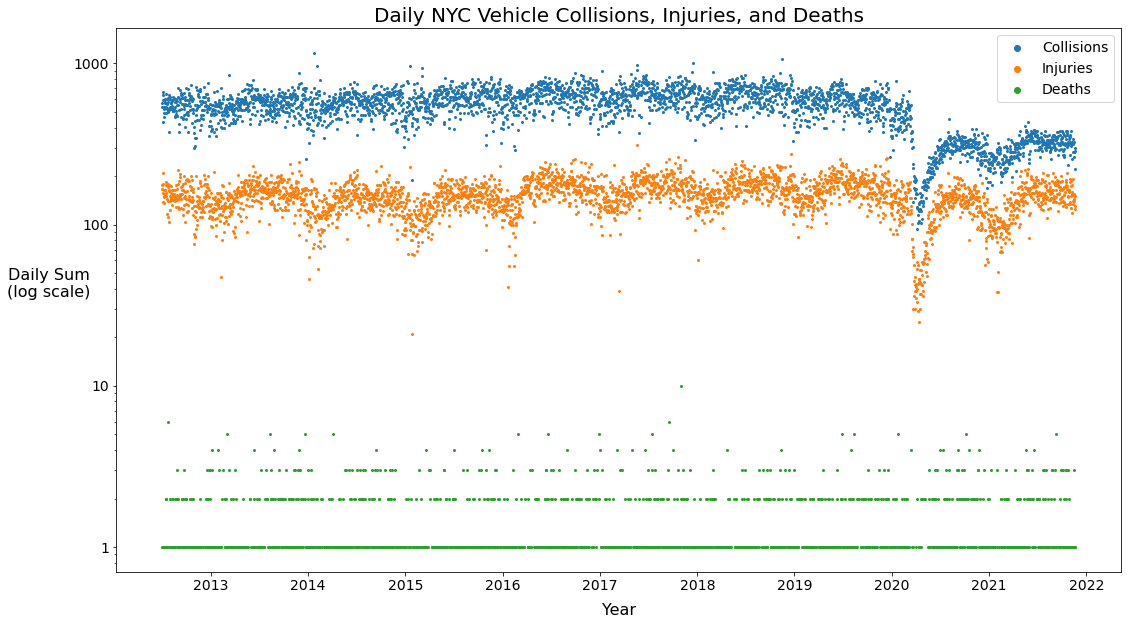

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches((18, 10))
ax.set_title("Daily NYC Vehicle Collisions, Injuries, and Deaths", fontsize=20)
ax.set_xlabel("Year", fontsize=16, labelpad=10)
ax.set_ylabel("Daily Sum\n(log scale)", fontsize=16, rotation=0, labelpad=25)
ax.tick_params(axis="both", which="major", labelsize=14)
ax.set_yscale("log")
ax.yaxis.set_major_formatter("{x:.0f}")
ax.scatter(y=daily_collisions, x=daily_collisions.index, s=4)  # s is marker size
ax.scatter(y=daily_injuries, x=daily_injuries.index, s=4)
ax.scatter(y=daily_deaths, x=daily_deaths.index, s=4)
ax.legend(["Collisions", "Injuries", "Deaths"], fontsize=14, markerscale=3)
plt.show()

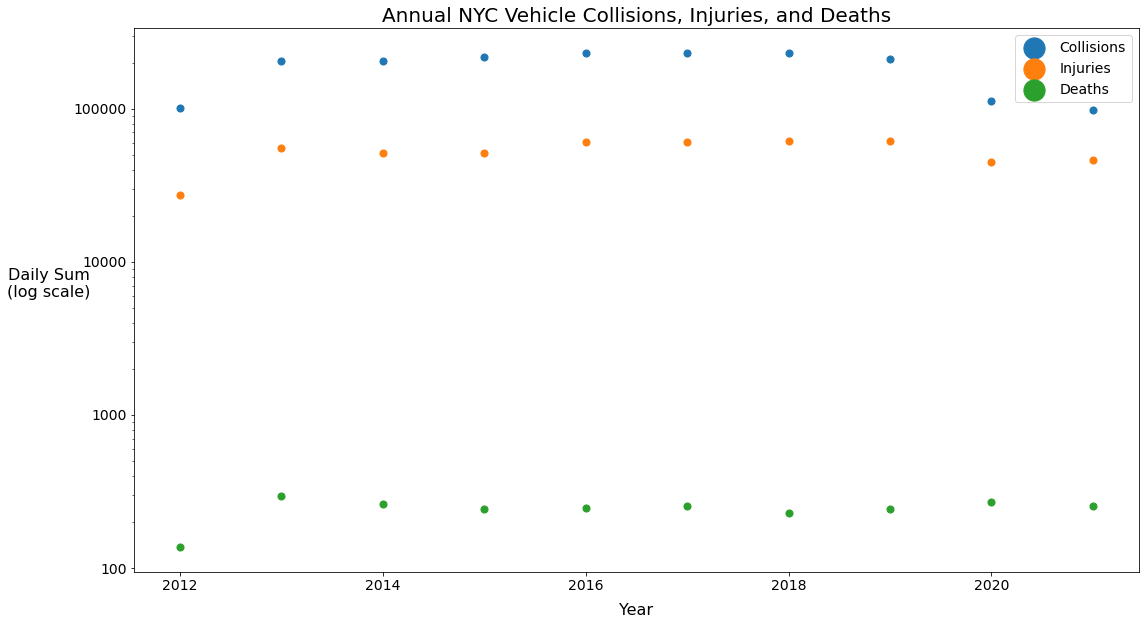

In [16]:
annual_collisions = data.groupby(by=data["datetime"].dt.year)["COLLISION_ID"].count()
annual_injuries = data.groupby(by=data["datetime"].dt.year)[
    "NUMBER OF PERSONS INJURED"
].sum()
annual_deaths = data.groupby(by=data["datetime"].dt.year)[
    "NUMBER OF PERSONS KILLED"
].sum()
fig, ax = plt.subplots()
fig.set_size_inches((18, 10))
ax.set_title("Annual NYC Vehicle Collisions, Injuries, and Deaths", fontsize=20)
ax.set_xlabel("Year", fontsize=16, labelpad=10)
ax.set_ylabel("Daily Sum\n(log scale)", fontsize=16, rotation=0, labelpad=25)
ax.tick_params(axis="both", which="major", labelsize=14)
ax.set_yscale("log")
ax.yaxis.set_major_formatter("{x:.0f}")
ax.scatter(y=annual_collisions, x=annual_collisions.index, s=50)  # s is marker size
ax.scatter(y=annual_injuries, x=annual_injuries.index, s=50)
ax.scatter(y=annual_deaths, x=annual_deaths.index, s=50)
ax.legend(["Collisions", "Injuries", "Deaths"], fontsize=14, markerscale=3)
plt.show()

In [17]:
data["datetime"].min(), data["datetime"].max()

(Timestamp('2012-07-01 00:05:00'), Timestamp('2021-11-20 23:49:00'))

- __There does not appear to a significant gap in data collection going back to the start of the data set (July 2012)__
- __Fatal collisions are a small percentage of the dataset. Collisions with injuries are more common__
- __Let's limit the scope of analysis to 1 October 2012 to 30 September 2021, a 9 year span, for reproducibility purposes__

In [18]:
start = datetime(year=2012, month=10, day=1)
end = datetime(year=2021, month=10, day=1)
crashes = data[data["datetime"].between(start, end, inclusive="left")].copy()
crashes["datetime"].min(), crashes["datetime"].max()

(Timestamp('2012-10-01 00:08:00'), Timestamp('2021-09-30 23:50:00'))

# Does 'NUMBER OF PERSONS INJURED' match the separate 'INJURED' categories?

In [19]:
crashes["sum injured categories"] = (
    crashes["NUMBER OF PEDESTRIANS INJURED"]
    + crashes["NUMBER OF CYCLIST INJURED"]
    + crashes["NUMBER OF MOTORIST INJURED"]
)
num_mismatch = len(
    crashes[crashes["sum injured categories"] != crashes["NUMBER OF PERSONS INJURED"]]
)
num_mismatch

2149

In [20]:
num_mismatch / len(crashes)

0.0012097738921899497

There do appear to be ~2100 collisions (or < 0.2% of total collisions) where the 'NUMBER OF PERSONS INJURED' field does not match the sum of the distinct injured categories (pedestrian, cyclist, motorist)

In [21]:
total_injured = crashes["NUMBER OF PERSONS INJURED"].sum()
difference = (
    crashes["NUMBER OF PERSONS INJURED"].sum() - crashes["sum injured categories"].sum()
)
difference

1799.0

In [22]:
(difference / total_injured)

0.0036135236978057737

- The cumulative discrepancy between the 'NUMBER OF PERSONS INJURED' field and the sum of the distinct injury fields (pedestrian, cyclist, motorist) is ~1800 injuries or < 0.4%
- __Given the relatively small difference, we will use the distinct 'injury' fields in our analyses going forward__


# Does 'NUMBER OF PERSONS KILLED' match the separate 'KILLED' categories?

In [23]:
crashes["sum killed categories"] = (
    crashes["NUMBER OF PEDESTRIANS KILLED"]
    + crashes["NUMBER OF CYCLIST KILLED"]
    + crashes["NUMBER OF MOTORIST KILLED"]
)
len(crashes[crashes["sum killed categories"] != crashes["NUMBER OF PERSONS KILLED"]])

53

In [24]:
total_killed = crashes["NUMBER OF PERSONS KILLED"].sum()
difference_deaths = (
    crashes["NUMBER OF PERSONS KILLED"].sum() - crashes["sum killed categories"].sum()
)
difference_deaths

10.0

In [25]:
(difference_deaths / total_killed)

0.004312203536006899

- There are ~50 collisions with differences between the 'NUMBER OF PERSONS KILLED' field and the sum of the separate killed fields (pedestrian, cyclist, motorist). The 10 death discrepancy represents a small percent of the total deaths (< 0.5%)

- __Once again given the relatively small difference, we will use the distinct 'killed' fields in our analyses going forward__

# Are many serious collisions missing location information? 

- We define _serious_ as a collision that results in injury or death. 
- Future analyses will tend to focus on serious collisions

In [26]:
crashes["serious_accident"] = (crashes["NUMBER OF PERSONS INJURED"] > 0) | (
    crashes["NUMBER OF PERSONS KILLED"] > 0
)
crashes["lat_long_missing"] = crashes["LOCATION"].isna()

In [27]:
(len(crashes) - crashes["lat_long_missing"].sum()) / len(crashes)

0.88375474634999

~88% of collisions have lat_long coordinates

In [28]:
pd.crosstab(
    index=crashes["lat_long_missing"],
    columns=crashes["serious_accident"],
    margins=True,
    normalize=True,
)

serious_accident,False,True,All
lat_long_missing,,,
False,0.699298,0.184457,0.883755
True,0.093780,0.022465,0.116245
All,0.793078,0.206922,1.000000


In [29]:
contingency_table = pd.crosstab(
    index=crashes["lat_long_missing"], columns=crashes["serious_accident"]
)
chi2_results = scipy.stats.chi2_contingency(contingency_table)
p_val = chi2_results[1]
p_val

9.084356722808761e-60

In [30]:
# col, row indexing
percent_with_lat_long_that_are_serious = contingency_table[1][0] / (
    contingency_table[0][0] + contingency_table[1][0]
)
percent_with_lat_long_that_are_serious

0.20871969735092882

In [31]:
percent_missing_lat_long_that_are_serious = contingency_table[1][1] / (
    contingency_table[0][1] + contingency_table[1][1]
)
percent_missing_lat_long_that_are_serious

0.1932550098307941

In [32]:
percent_serious_missing_lat_long = contingency_table[1][1] / (
    contingency_table[1][0] + contingency_table[1][1]
)
percent_serious_missing_lat_long

0.10856737102421586

- The p-value of the Chi-squared test is ~0
- Using the Chi-squared test, we reject the null hypothesis that the percentage of collisions with injuries is the same for the population with lat-longs coordinates as for the population without lat-longs coordinates
- Approximately ~21% of the collisions that have lat-long coordinates are serious (with injuries or deaths)
- Approximately ~19% of the collisions that are missing coordinates are serious
- Serious collisions seem to be more likely to have lat-long coordinates with than less serious collisions
- ___The good news is that an analysis requiring lat-longs will not exclude data with a higher concentration of serious collisions___
- ___The bad news is that ~11% of serious accidents will be removed from the dataset by excluding collisions without lat-long coordinates___

A quick view of some serious accidents that are missing coordinates suggests that a more in-depth analysis could obtain approximate lat-long coordinates for some of the serious accidents based on other location data

In [33]:
serious_missing_location = crashes[
    (crashes["LOCATION"].isna()) & (crashes["serious_accident"] == True)
]
serious_missing_location[
    ["ON STREET NAME", "CROSS STREET NAME", "OFF STREET NAME"]
].head(20)

,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME
8,GOWANUS RAMP,NaN,NaN
10,BEVERLEY ROAD,EAST 21 STREET,NaN
129,PARSONS BLVD,90 AVENUE,NaN
130,STATEN ISLAND EXPRESSWAY,NaN,NaN
163,Trans- Manhattan Expressway,Amsterdam Avenue,NaN
183,REVIEW AVENUE,RAILROAD AVENUE,NaN
199,ARCHER AVENUE,GUY R BREWER BLVD,NaN
207,WILLIAMSBURG BRIDGE OUTER ROADWA,NaN,NaN
249,BRUCKNER BOULEVARD,EAST 135 STREET,NaN
252,G.C.P. / LAGUARDIA (CDR),NaN,NaN


# Does 'LOCATION' match the individual 'LATITUDE' and 'LONGITUDE' fields?

In [34]:
def loc_string_to_tuple(s):
    """Helper function to convert strings in 'LOCATION' to numeric tuple"""
    s = str(s)  # to handle 'nan's without checking type
    if s == "nan":
        ret = (float("nan"), float("nan"))
    else:
        s_list = s.strip().split(",")
        ret = tuple(float(s.strip("()")) for s in s_list)
    return ret


def tuples_match(tup1, tup2):
    """Check for tuple equality given that values may be float('nan'). 
    float('nan') != float('nan'). Returns Boolean"""
    if math.isnan(tup1[0]):
        return all([math.isnan(x) for x in (tup1 + tup2)])
    else:
        return tup1 == tup2

In [35]:
location = crashes["LOCATION"].apply(loc_string_to_tuple)
lat_long = list(zip(crashes["LATITUDE"], crashes["LONGITUDE"]))
matches = [tuples_match(x[0], x[1]) for x in zip(location, lat_long)]
all(matches)

True

__'LOCATION' matches the individual 'LATITUDE' and 'LONGITUDE' fields__

# Are there obviously wrong lat-long coordinates (far outside NYC)?

In [36]:
NYC_WEST_LIMIT = -74.30  # west of Staten Island
NYC_EAST_LIMIT = -73.70  # east of Queens / Lakeville Rd.
NYC_SOUTH_LIMIT = 40.45  # south of Staten Island
NYC_NORTH_LIMIT = 40.95  # north of the Bronx
crashes["good_lat_long"] = (
    crashes["LONGITUDE"].between(NYC_WEST_LIMIT, NYC_EAST_LIMIT)
) & (crashes["LATITUDE"].between(NYC_SOUTH_LIMIT, NYC_NORTH_LIMIT))

In [37]:
with_lat_long_sum = crashes[~crashes["lat_long_missing"]]["good_lat_long"].count()
good_lat_long_sum = crashes[~crashes["lat_long_missing"]]["good_lat_long"].sum()
good_lat_long_sum / with_lat_long_sum

0.9986310977143982

In [38]:
with_lat_long_sum - good_lat_long_sum

2149

- ~99.9% (or all but 2149) of the collisions that have coordinates, have coordinates that are in vicinity of NYC. 

# Conclusions

- The data contains time, location (in most cases), and the number of people injured or killed in automobile collisions dating back to 2012
- There do not appear to be any significant gaps in data collection going back to 2012
- There are some minor inconsistencies betweeen the total number of people injured or killed and their respective breakdown into pedestrian, cyclist, and motorist categories. We will be using the distinct categories going forward rather than the provided sum. The sum injured and killed fields can be recomputed from the separate categories
- ~12% of collisions are missing location data
- The 'LOCATION' field matches "LATITUDE' and 'LONGITUDE' with no inconsistencies 
- ~99.9% of collisions with location data have coordinates that correspond to the NYC area